# Practicals in Seismology, winter semester 2024/25

---
#### Week 5, 20 November 2024
#### Topic: Herglotz-Wiechert analysis
#### Responsible: Yajian Gao

---
**In this week's practicals you recapulate how to work with array data and learn/practice**

* how to determine slowness and backazimuth of an arriving phase
* how the ray parameter varies with the distance to the earthquake
* how to use the ray parameter to create a 1D velocity model of the Earth

---


First you will import the necessary python packages which are required for this exercise:
- numpy
- obspy (including read and UTCDateTime)

In [1]:
#import packages
import obspy
from obspy import UTCDateTime, read

Similar to the last practical we need to import functions from an additional file. Therefore, run the cell below.

In [2]:
import sys
sys.path.append('scripts')
from utils import *

## Herglotz-Wiechert analysis

In the beginning of the 20th century Emil Wiechert and Gustav Herglotz established a method to create a 1D velocity model of the Earth by using information about the ray parameter and the epicentral distance. <br> 
Generally, the ray parameter is estimated by the derivative of travel time curves. Those curves were determined by measuring the arrival time of earthquake phases at multiple stations, which are spread over the globe. With the advantage of data of a seismic array, we can simplify the determination of the ray parameter! <br>
As you might remember from the lecture, the ray parameter $p=\frac{r}{v}* \sin(i)$ (spherical case) is constant along the ray path: <br>

<img src="data/HW_parameter.png" alt="drawing" width="400"> <br>
<br>
On the surface the ray parameter can be measured with the slowness:
<center>$s=\frac{1}{v_{hor}}=\frac{1}{v}* \sin(i)$</center>  <br><br>
With the equations for traveltime and epicentral distance (with $\phi=\frac{r}{v}$):<br>
<center>$T=2\int_{r_m}^{r_0}\frac{\phi^2\text{d}r}{r\sqrt{\phi^2-p^2}}$    </center> <br>
<center>$\Delta=2\int_{r_m}^{r_0}\frac{p \text{d}r}{r\sqrt{\phi^2-p^2}}$   </center>
we can derive the equation for the Herglotz-Wiechert inversion:
<br><br>
<center>$\text{ln}\frac{r_0}{r_1}= \frac{1}{\pi}\int_0^{\Delta_1}\text{arccosh} \frac{p}{p_1}\text{d}\Delta =\frac{A}{\pi} $   </center>
<br><br>
After we calculated the integral $A$, we can determine the deepest point of the raypath, at which the incident angle i will be 90°. Then, we can determine the velocity for the given depth. <br><br>

<center>$r_1=r_0 e^{-\frac{A}{\pi}}$  and $v_1=\frac{r_1}{p_1}$   </center>
<br><br>

In this practical we will follow the steps of Herglotz and Wiechert and create a simple 1D velocity model of the Earth<br>
This practical is divided in three parts:<br>
1) Data collection (slowness, distance)<br>
2) Inversion (velocity, depth)<br>
3) *Bonus: comparison with results obtained by travel times of the ak135 tables*<br>



### 1) Collect slowness data for earthquakes in various distances

As we need information of the variation of the ray parameter over the epicentral distance, we can determine the slowness for earthquakes in multiple distances.<br>
We provided data for several earthquakes and if every student determines the slowness (P-phase) of one or two, than we will have enough for the inversion. <br>
Here is a list of the earthquakes:

<img src="data/eq_list.png" alt="drawing" width="550"> <br>

The following steps are now carried out for the individual earthquake. If someone of you finishes earlier, just repeat the steps with a different earthquake and then you can compare the results.

In [3]:
P_arrival=["2020-07-08T05:19:56","2019-11-27T07:27:24","2020-06-21T19:12:56","2015-02-13T19:04:54","2017-11-12T18:24:15","2015-12-07T07:58:17.86","2016-08-29T04:39:37","2015-4-25T06:21:22","2020-09-18T21:53:54","2020:01:28T19:22:14"]


In [60]:
P_arrival

['2020-07-08T05:19:56',
 '2019-11-27T07:27:24',
 '2020-06-21T19:12:56',
 '2015-02-13T19:04:54',
 '2017-11-12T18:24:15',
 '2015-12-07T07:58:17.86',
 '2016-08-29T04:39:37',
 '2015-4-25T06:21:22',
 '2020-09-18T21:53:54',
 '2020:01:28T19:22:14']

In [4]:
lat_list=np.array([51.566,35.717,66.381,52.649,34.911,38.211,-0.046,28.147,0.917,19.419])
lon_list=np.array([16.249,23.228,18.707,-31.902,45.959,72.78,-17.826,84.708,-26.841,-78.756])

#### a) Determine the distance to the earthquake 

In order to determine the distance, the function <code>calc_distance</code> is available. Please run the cell below.

In [5]:
def calc_distance(lo1,la1,lo2,la2):
    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(sqrt(a), sqrt(1 - a))
    return(c*360/2/np.pi)

Determine the distance between your earthquake and the array (coordinates of array: 49.3°N 11.5°E). 

In [7]:
#calculate the distance and print the results
distance=np.zeros(len(lat_list))
for i in range(len(lat_list)):
    distance[i]=calc_distance(lon_list[i],lat_list[i],11.5,49.3)

In [8]:
distance

array([ 3.77835228, 16.05890534, 17.47915019, 27.11309546, 28.97876466,
       44.34334906, 55.39460461, 58.41588168, 58.43068087, 75.56319451])

#### b) Determine the slowness
Read the data of the day with the earthquake and cut a reasonable time window. <br>



In [9]:
#read the data of all stations and the day of "your earthquake" with read()


#trim your stream in a reasonable time window (40 seconds before and 80 seconds after the P-onset). P-onsets are given below. Choose the onset of 'your' earthquake.
P_arrival=["2020-07-08T05:19:56","2019-11-27T07:27:24","2020-06-21T19:12:56","2015-02-13T19:04:54","2017-11-12T18:24:15","2015-12-07T07:58:17.86","2016-08-29T04:39:37","2015-4-25T06:21:22","2020-09-18T21:53:54","2020:01:28T19:22:14"]



In [10]:
print(P_arrival[3],distance[3])
#"2019-11-27T07:27:24")

2015-02-13T19:04:54 27.113095464114682


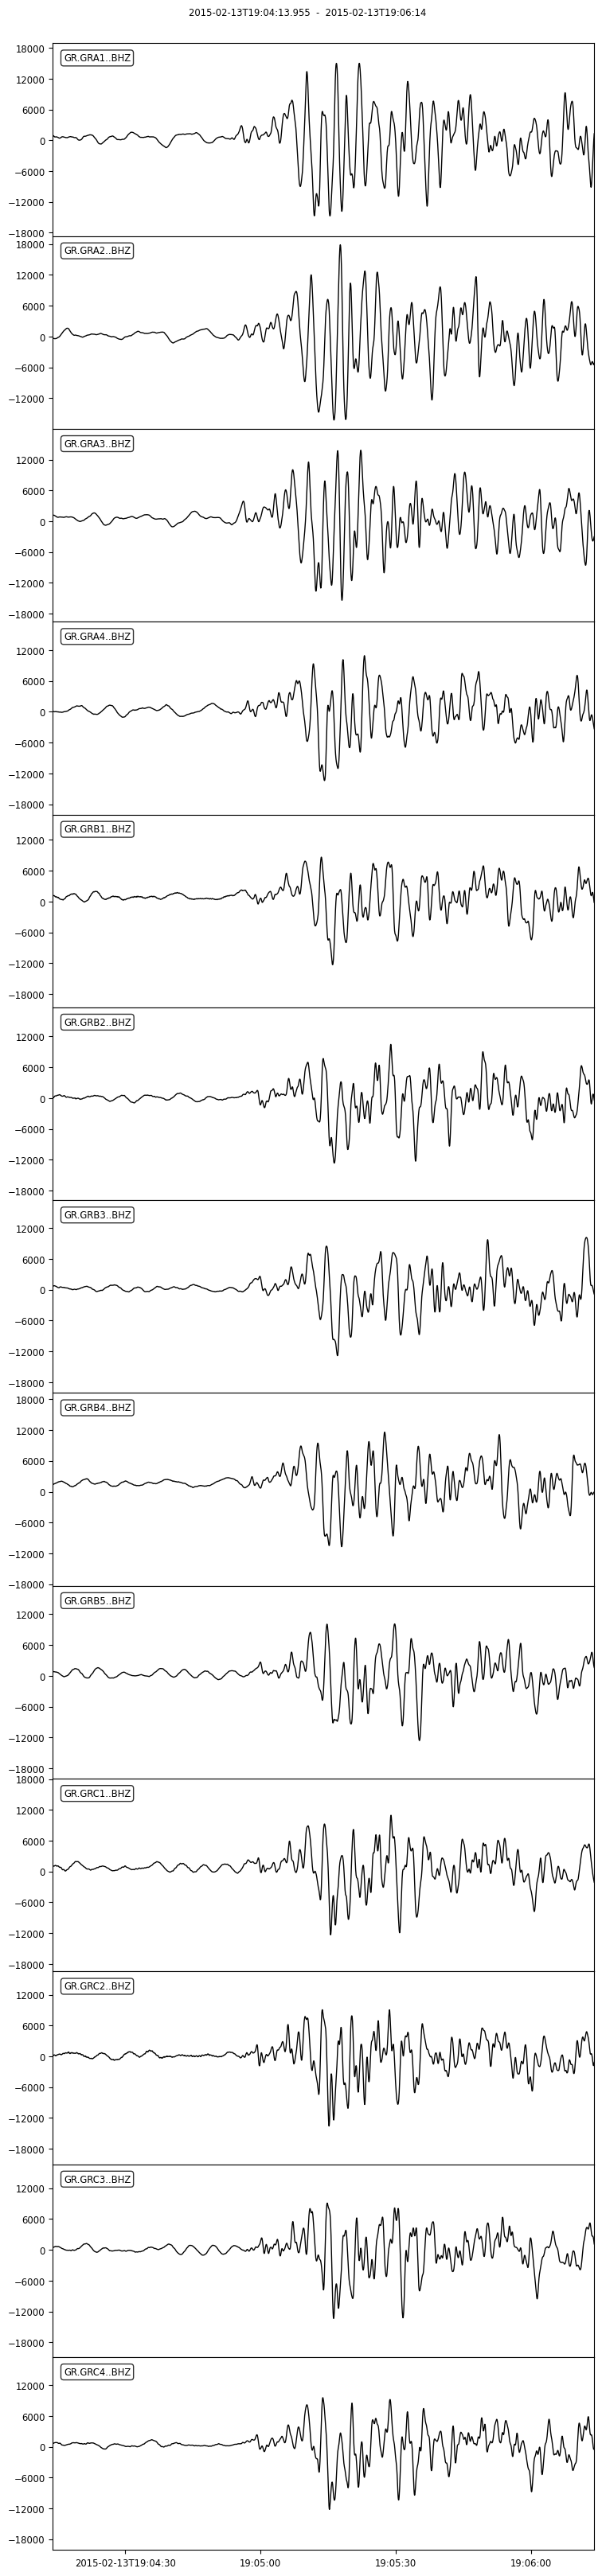

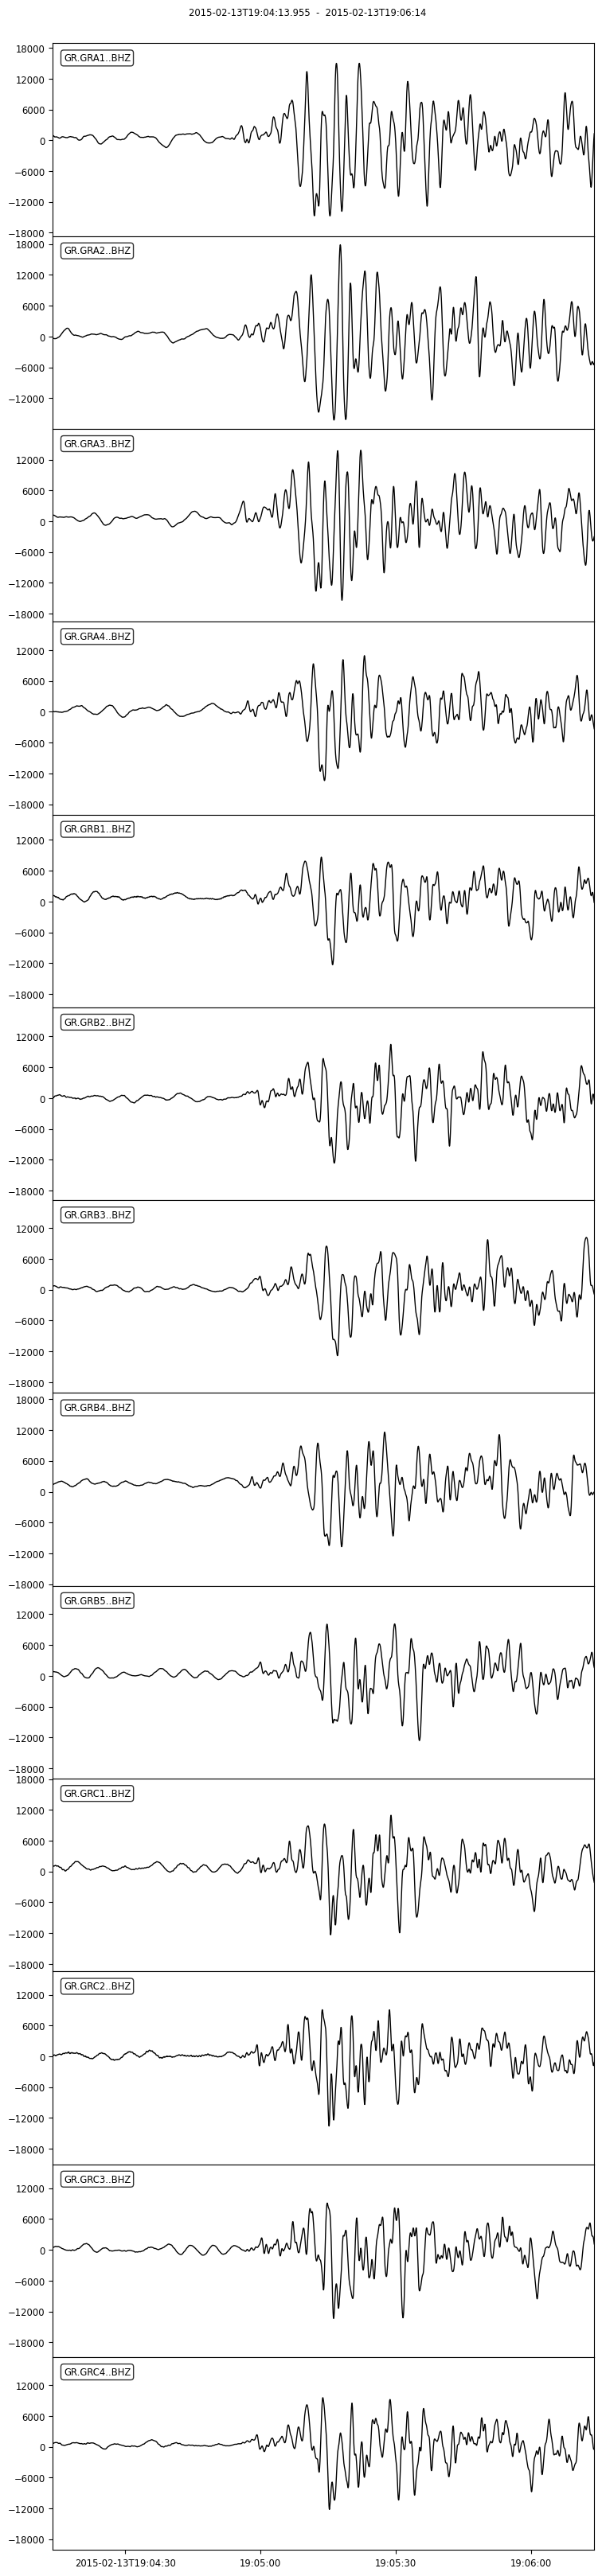

In [11]:
from obspy import read
##"2015-02-13T19:04:54"
st=read('data/GR.GR*2015.044*')
time_P=obspy.UTCDateTime(P_arrival[3])
st2=st.copy()
st2.trim(time_P-40,time_P+80)
st2.plot()

Define the parameters, which are relevant for the array analysis. You can find some suggestions in the box below. Depending on the distance to your earthquake you might consider changing the parameters. Compute your array analysis for a time window of 30 seconds, from 5 seconds before to 25 seconds after the P-onset.

In [12]:
start=UTCDateTime(P_arrival[3])-5
end=UTCDateTime(P_arrival[3])+25
fmin    =  0.005  
fmax    =  0.5
win_len =  10
smax    =  0.15

Carry out the array analysis in order to determine the slowness! <br>
Remember, that you can use <code>%matplotlib qt5</code> to display a figure in an external window.

In [15]:
%matplotlib qt5
baz,slow=array_hist_st(st2,start,end,fmin=fmin, fmax=fmax,win_len=win_len,smax=smax, stationfile='data/station_GR.csv')

calculating fk-diagram with:
sll_x:  -0.15
slm_x:  0.15
sll_y:  -0.15
slm_y:  0.15
sl_s:  0.003
2015-02-13T19:04:48.979999Z 2015-02-13T19:05:18.979999Z
fk processing for signal between 2015-02-13T19:04:48.979999Z and 2015-02-13T19:05:18.979999Z...


In [16]:
baz,slow

(5.1487212933832724, 0.076875)

In [14]:
5.1487212933832724*180/np.pi

295.0

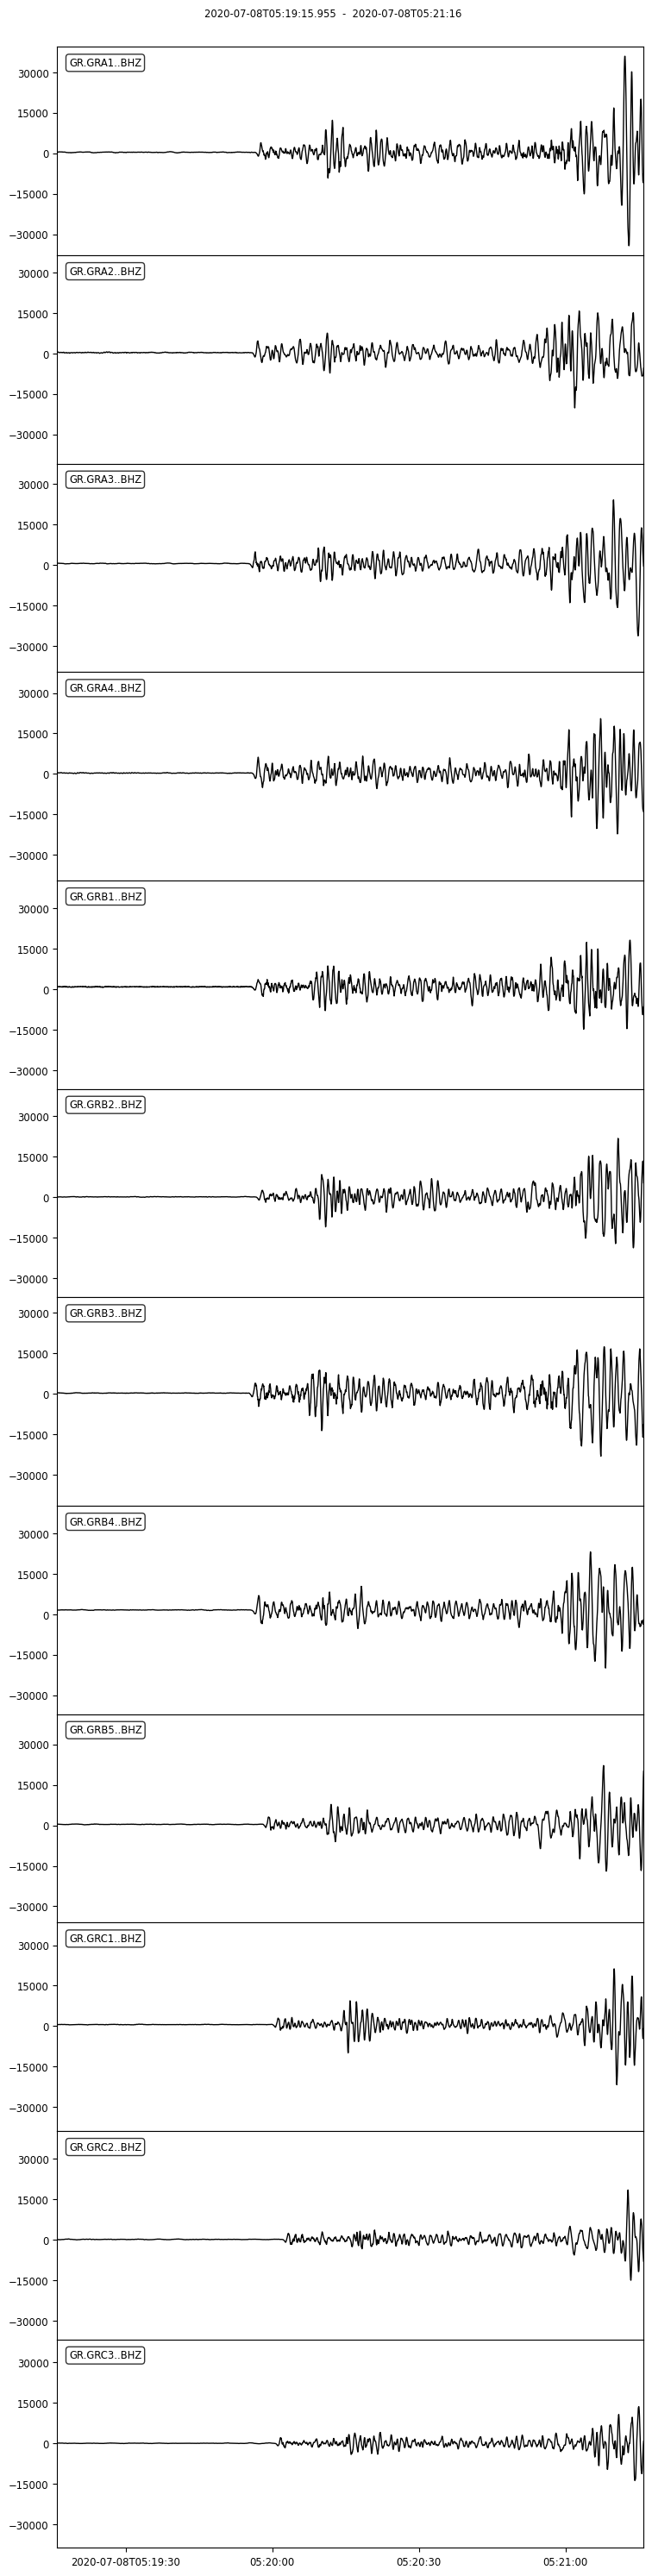

In [13]:
from obspy import read
##"2020-07-08T05:19:56"
st=read('data/GR.GR*..BHZ.D.2020.190*')
time_P=obspy.UTCDateTime("2020-07-08T05:19:56")
st2=st.copy()
st2.trim(time_P-40,time_P+80)
st2.plot()

In [18]:
start=UTCDateTime(P_arrival[0])-2
end=UTCDateTime(P_arrival[0])+9
fmin    =  0.005  
fmax    =  0.5
win_len =  8
smax    =  0.15
%matplotlib qt5
array_hist_st(st2,start,end,fmin=fmin, fmax=fmax,win_len=win_len,smax=smax, stationfile='data/station_GR.csv')

Qt: Session management error: Authentication Rejected, reason : None of the authentication protocols specified are supported and host-based authentication failed


calculating fk-diagram with:
sll_x:  -0.15
slm_x:  0.15
sll_y:  -0.15
slm_y:  0.15
sl_s:  0.003
2020-07-08T05:19:53.979999Z 2020-07-08T05:20:04.979999Z
fk processing for signal between 2020-07-08T05:19:53.979999Z and 2020-07-08T05:20:04.979999Z...


In [19]:
print(distance[1],P_arrival[1])

16.058905343629203 2019-11-27T07:27:24


16.058905343629203 2019-11-27T07:27:24


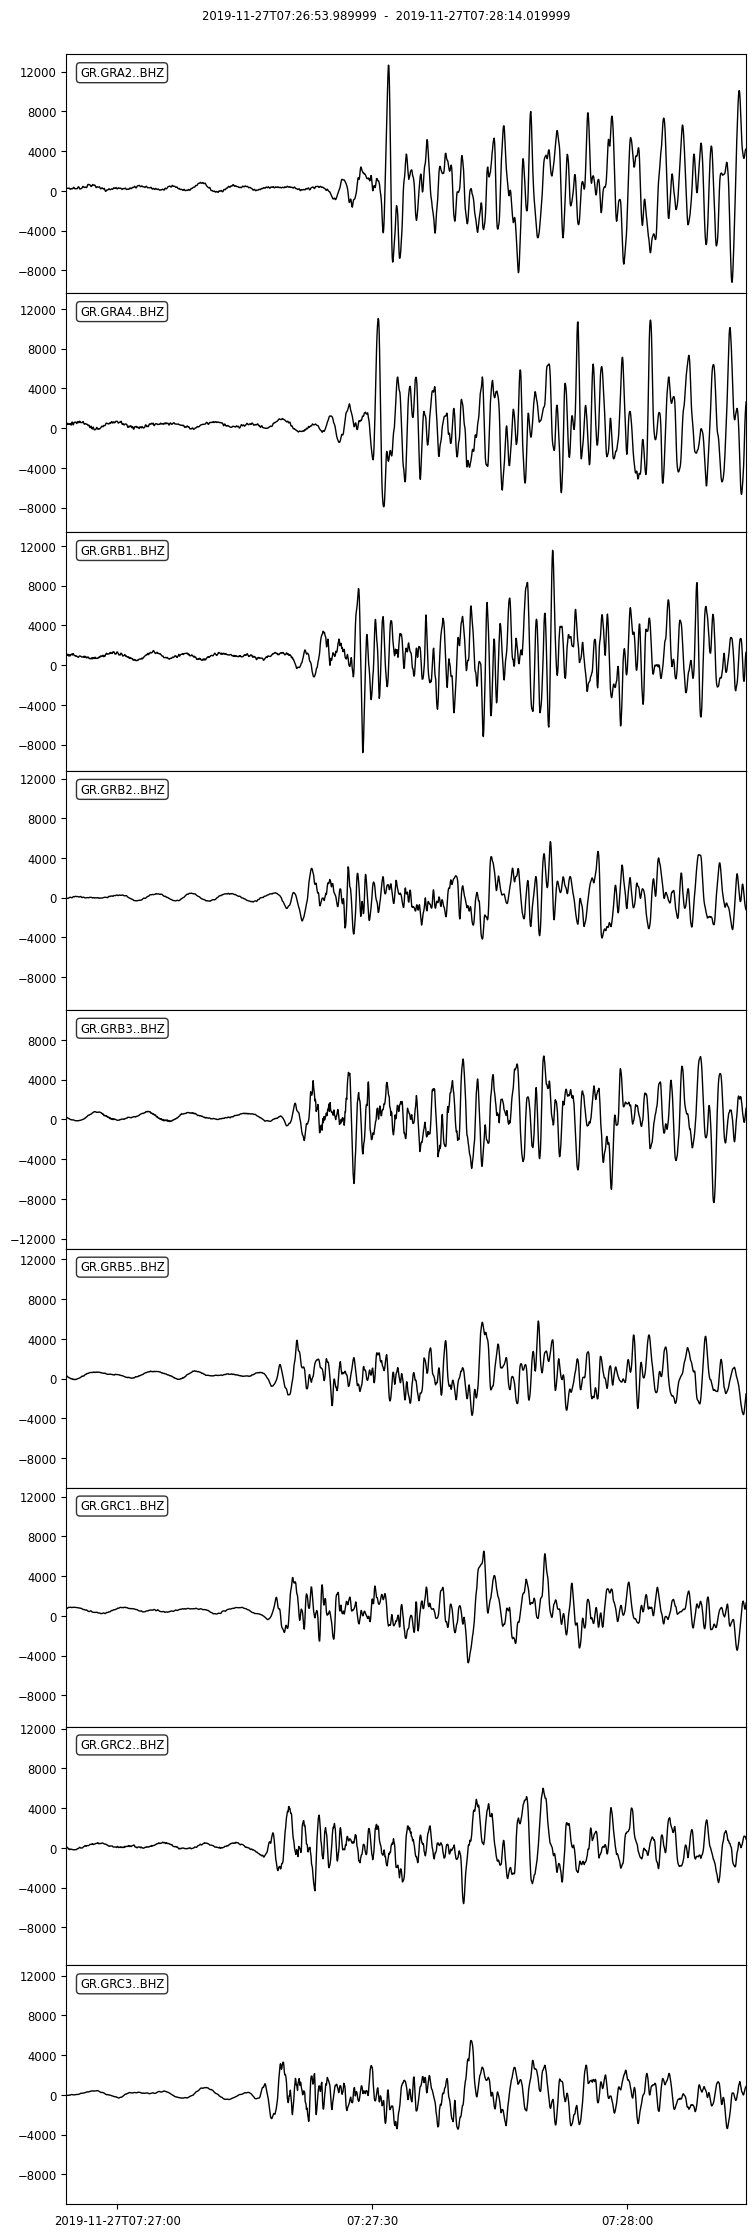

In [14]:
print(distance[1],P_arrival[1])
from obspy import read
#"2019-11-27T07:27:24"
st=read('data/GR.GR*.BHZ.D.2019.331')
time_P=obspy.UTCDateTime(P_arrival[1])
st2=st.copy()
st2.trim(time_P-30,time_P+50)
st2.plot()

In [15]:
##be careful, the P pick is not so accurate
start=UTCDateTime(P_arrival[1])-10
end=UTCDateTime(P_arrival[1])+30
fmin    =  0.005  
fmax    =  0.5
win_len =  20
smax    =  0.15
%matplotlib qt5
array_hist_st(st2,start,end,fmin=fmin, fmax=fmax,win_len=win_len,smax=smax, stationfile='data/station_GR.csv')

calculating fk-diagram with:
sll_x:  -0.15
slm_x:  0.15
sll_y:  -0.15
slm_y:  0.15
sl_s:  0.003
2019-11-27T07:27:13.995000Z 2019-11-27T07:27:53.995000Z
fk processing for signal between 2019-11-27T07:27:13.995000Z and 2019-11-27T07:27:53.995000Z...


In [23]:
print(P_arrival[2],distance[2])

2020-06-21T19:12:56 17.479150192636315


2020-06-21T19:12:56


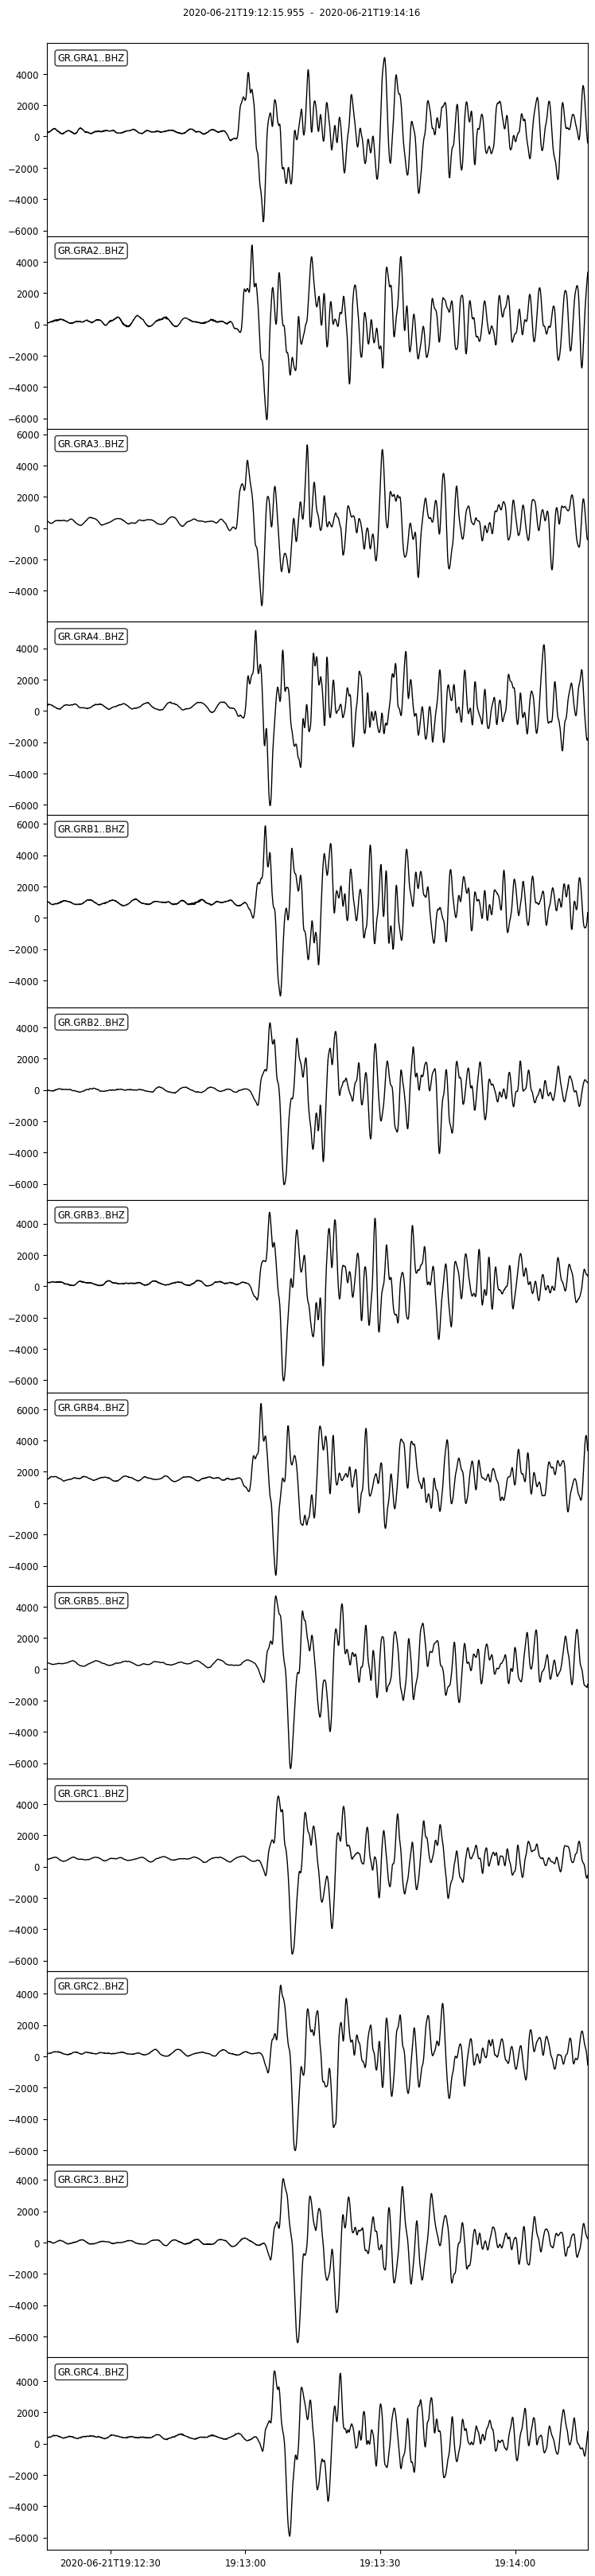

In [16]:
from obspy import read
print(P_arrival[2])
#"2019-11-27T07:27:24"
st=read('data/GR.GR*.2020.173')
time_P=obspy.UTCDateTime(P_arrival[2])
st2=st.copy()
st2.trim(time_P-40,time_P+80)
st2.plot()

In [17]:
from obspy import read
print(P_arrival[2])
#"2019-11-27T07:27:24"
st=read('data/GR.GR*.2020.173')
time_P=obspy.UTCDateTime(P_arrival[2])
st2=st.copy()
st2.trim(time_P-10,time_P+50)
#st2.plot()

start=UTCDateTime(P_arrival[2])-5
end=UTCDateTime(P_arrival[2])+30
fmin    =  0.005  
fmax    =  0.5
win_len =  30
smax    =  0.2
%matplotlib qt5
array_hist_st(st2,start,end,fmin=fmin, fmax=fmax,win_len=win_len,smax=smax, stationfile='data/station_GR.csv')

2020-06-21T19:12:56
calculating fk-diagram with:
sll_x:  -0.2
slm_x:  0.2
sll_y:  -0.2
slm_y:  0.2
sl_s:  0.004
2020-06-21T19:12:50.979999Z 2020-06-21T19:13:25.979999Z
fk processing for signal between 2020-06-21T19:12:50.979999Z and 2020-06-21T19:13:25.979999Z...


In [18]:
print(P_arrival[4],distance[4])

2017-11-12T18:24:15 28.978764656812228


In [19]:

print(P_arrival[4])
#"2019-11-27T07:27:24"
st=read('data/GR.GR*..BHZ.D.2017.316')
time_P=obspy.UTCDateTime(P_arrival[4])
st2=st.copy()
st2.trim(time_P-40,time_P+80)
#st2.plot()

start=UTCDateTime(P_arrival[4])-2
end=UTCDateTime(P_arrival[4])+14
fmin    =  0.005  
fmax    =  0.5
win_len =  12
smax    =  0.15
%matplotlib qt5
array_hist_st(st2,start,end,fmin=fmin, fmax=fmax,win_len=win_len,smax=smax, stationfile='data/station_GR.csv')

2017-11-12T18:24:15
calculating fk-diagram with:
sll_x:  -0.15
slm_x:  0.15
sll_y:  -0.15
slm_y:  0.15
sl_s:  0.003
2017-11-12T18:24:13.009999Z 2017-11-12T18:24:29.009999Z
fk processing for signal between 2017-11-12T18:24:13.009999Z and 2017-11-12T18:24:29.009999Z...


In [20]:
print(P_arrival[5],distance[5])

2015-12-07T07:58:17.86 44.34334905836662


In [21]:

print(P_arrival[5])
#"2019-11-27T07:27:24"
st=read('data/GR.GR*..BHZ.D.2015.341')
time_P=obspy.UTCDateTime(P_arrival[5])
st2=st.copy()
st2.trim(time_P-40,time_P+80)
#st2.plot()

start=UTCDateTime(P_arrival[5])-2
end=UTCDateTime(P_arrival[5])+14
fmin    =  0.005  
fmax    =  0.5
win_len =  12
smax    =  0.15
%matplotlib qt5
array_hist_st(st2,start,end,fmin=fmin, fmax=fmax,win_len=win_len,smax=smax, stationfile='data/station_GR.csv')

2015-12-07T07:58:17.86
calculating fk-diagram with:
sll_x:  -0.15
slm_x:  0.15
sll_y:  -0.15
slm_y:  0.15
sl_s:  0.003
2015-12-07T07:58:15.855000Z 2015-12-07T07:58:31.855000Z
fk processing for signal between 2015-12-07T07:58:15.855000Z and 2015-12-07T07:58:31.855000Z...


In [26]:
print(P_arrival[6],distance[6])

2016-08-29T04:39:37 55.39460461203017


2016-08-29T04:39:37


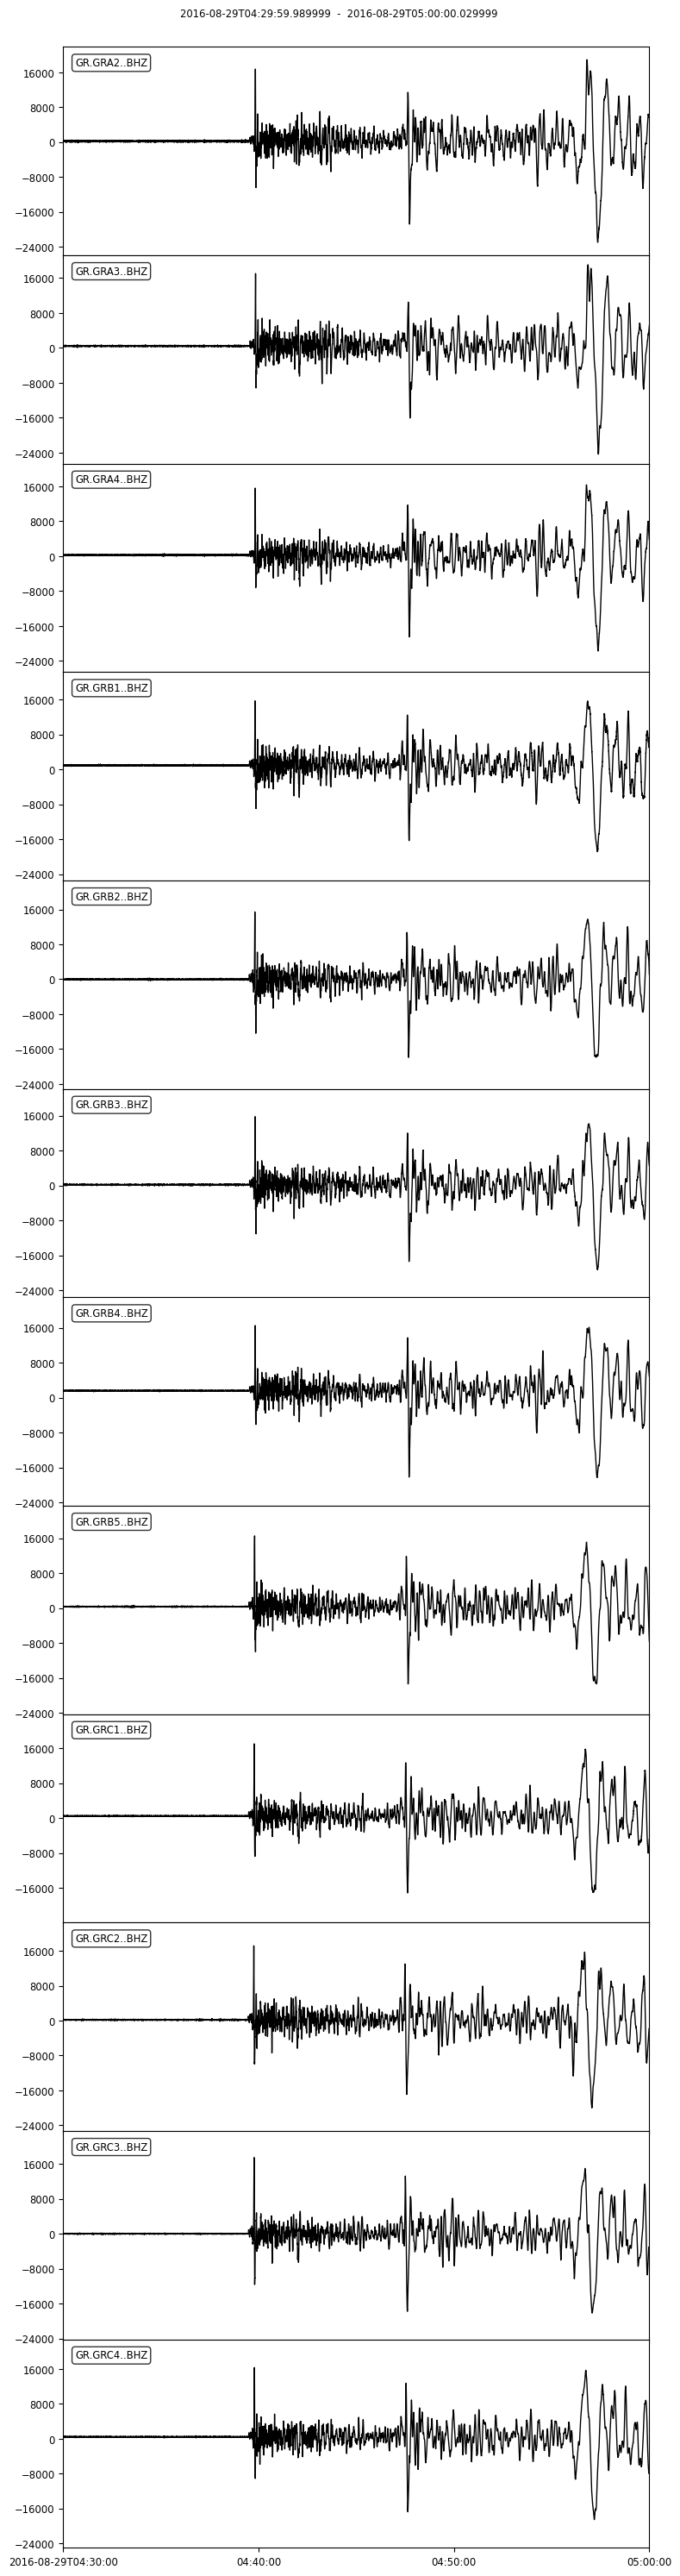

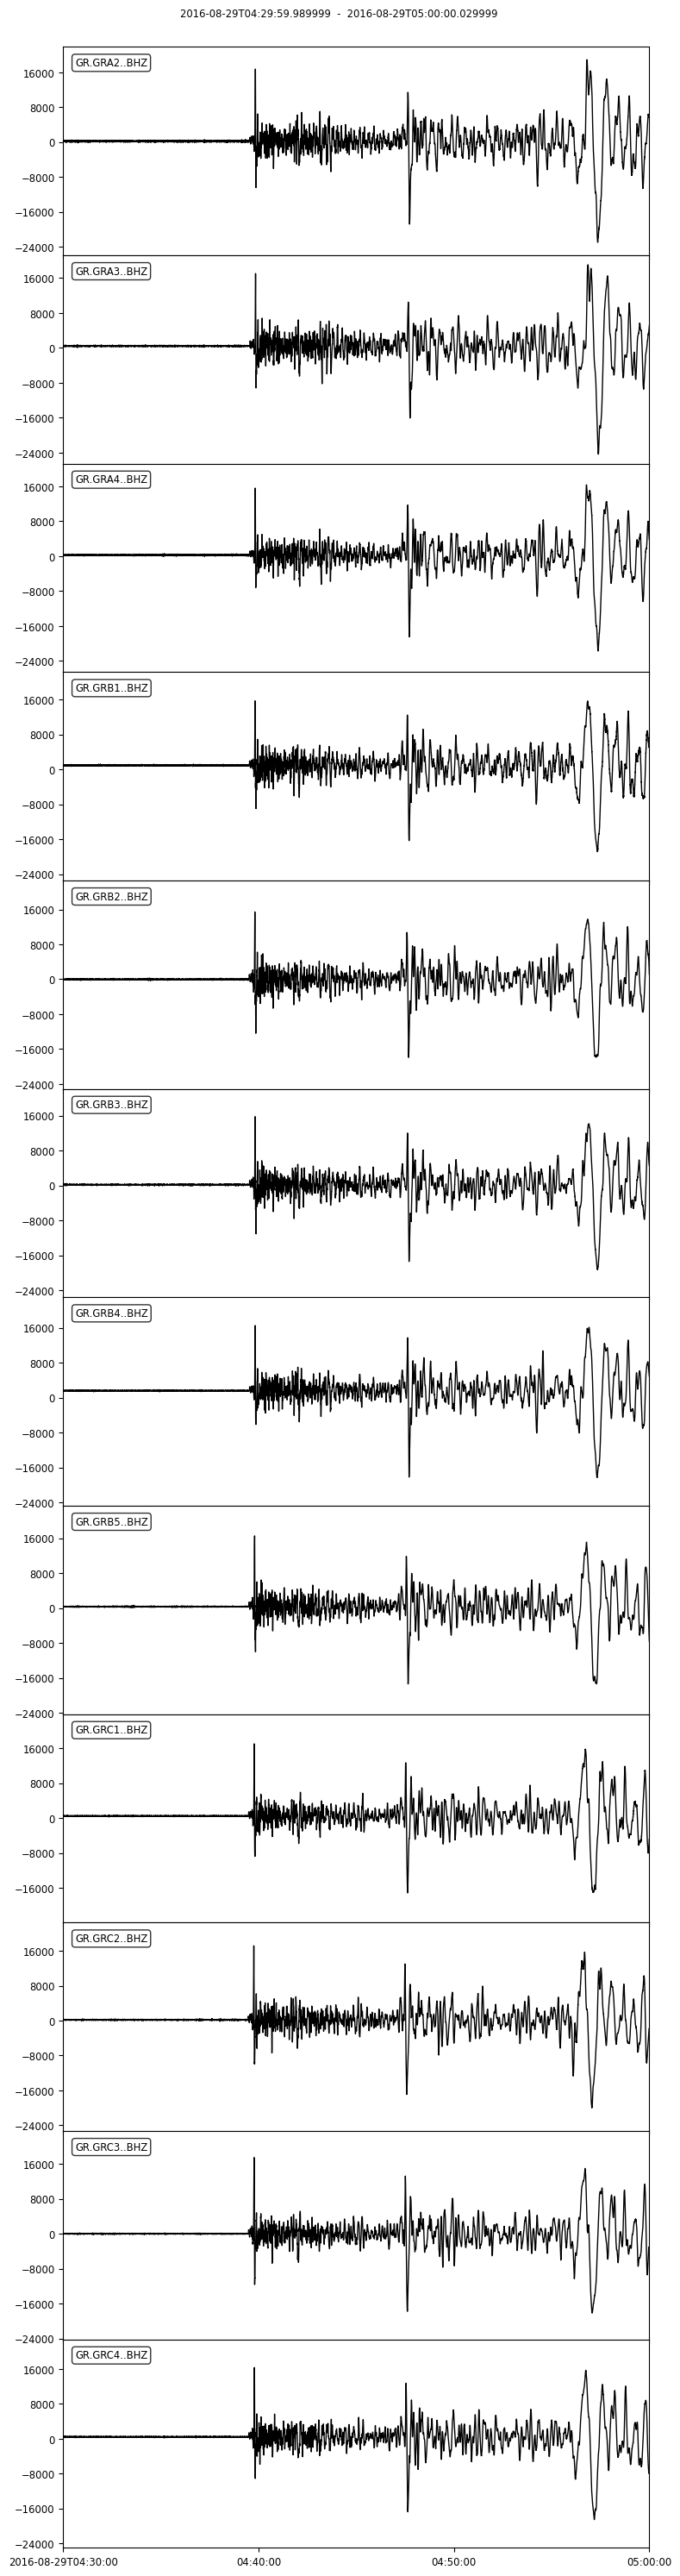

In [27]:
%matplotlib inline
print(P_arrival[6])
#"2019-11-27T07:27:24"
st=read('data/GR.GR*..BHZ.D.2016.242')
start=obspy.UTCDateTime('2016-08-29T04:30:00')
end=obspy.UTCDateTime('2016-08-29T05:00:00')
st2=st.copy()
st2.trim(start,end)
st2.plot()

In [28]:
from obspy.taup import TauPyModel
model = TauPyModel(model='ak135')
arrivals = model.get_ray_paths(15, 55)
time_p=arrivals[0].time

In [29]:
time_p

570.675705863194

In [30]:
obspy.UTCDateTime('2016-08-29T04:29:57')+570.65

2016-08-29T04:39:27.650000Z

2016-08-29T04:39:37


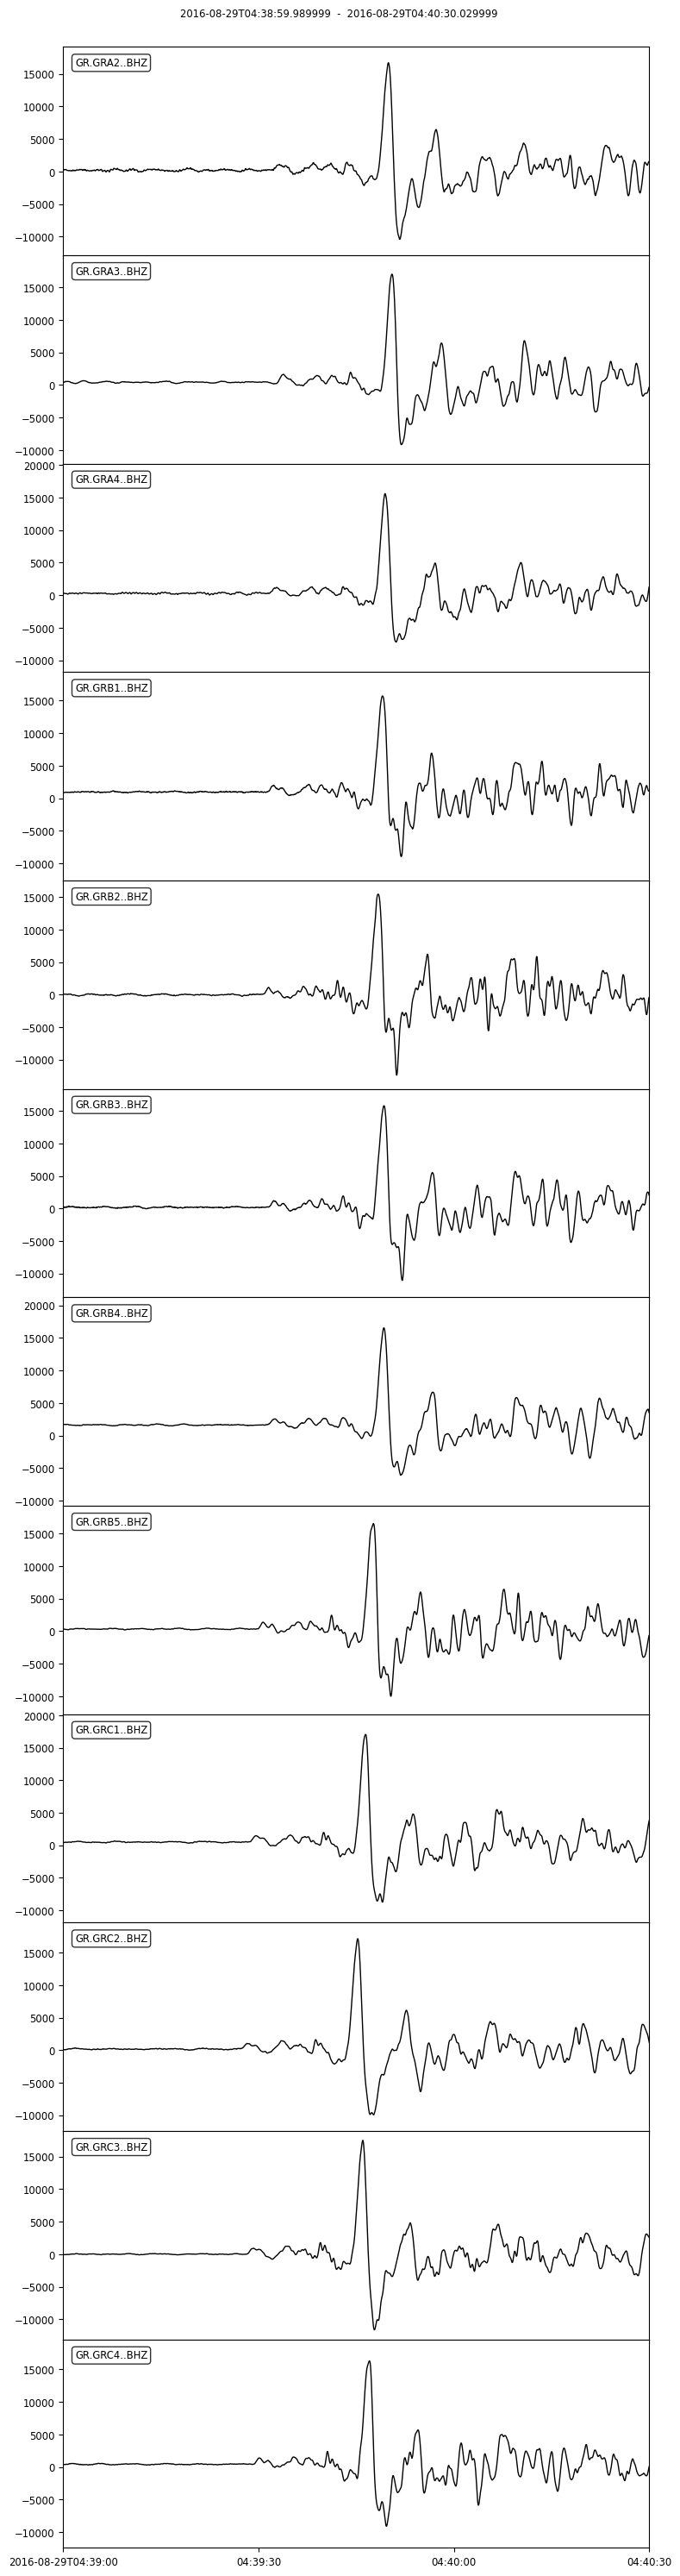

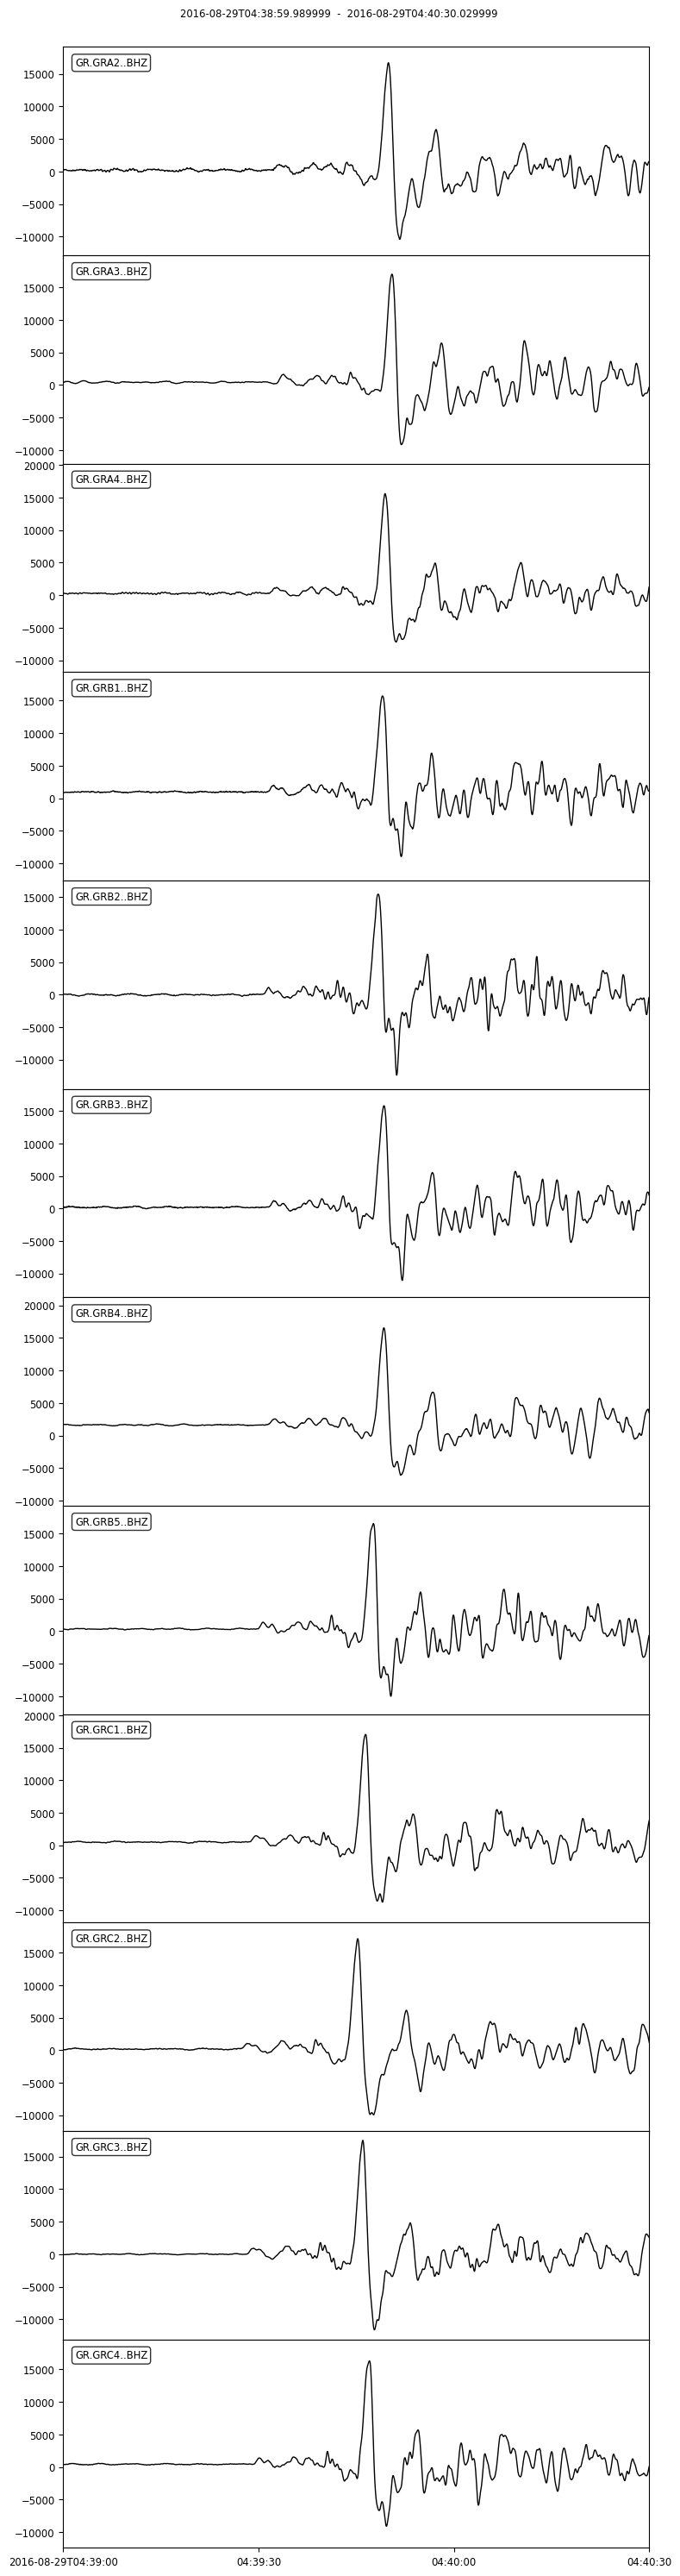

In [31]:
%matplotlib inline
print(P_arrival[6])
#"2019-11-27T07:27:24"
st=read('data/GR.GR*..BHZ.D.2016.242')
time_P=obspy.UTCDateTime(P_arrival[6])-7
st2=st.copy()
st2.trim(time_P-30,time_P+60)
st2.plot()

In [ ]:
time_P

In [32]:
%matplotlib inline
print(P_arrival[6])
#"2019-11-27T07:27:24"
st=read('data/GR.GR*..BHZ.D.2016.242')
time_P=obspy.UTCDateTime(P_arrival[6])
st2=st.copy()
st2.trim(time_P-30,time_P+30)
#st2.plot()
###here should be careful, the p pick is not so accurate
start=UTCDateTime(P_arrival[6])-10-5
end=UTCDateTime(P_arrival[6])-10+20
fmin    =  0.005  
fmax    =  0.5
win_len =  20
smax    =  0.15
%matplotlib qt5
array_hist_st(st2,start,end,fmin=fmin, fmax=fmax,win_len=win_len,smax=smax, stationfile='data/station_GR.csv')

2016-08-29T04:39:37
calculating fk-diagram with:
sll_x:  -0.15
slm_x:  0.15
sll_y:  -0.15
slm_y:  0.15
sl_s:  0.003
2016-08-29T04:39:22.000000Z 2016-08-29T04:39:47.000000Z
fk processing for signal between 2016-08-29T04:39:22.000000Z and 2016-08-29T04:39:47.000000Z...


In [33]:
%matplotlib inline
print(P_arrival[7],distance[7])

2015-4-25T06:21:22 58.41588168329865


2015-4-25T06:21:22


/work/software/conda/2022.05/envs/seispy_env/lib/python3.9/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/work/software/conda/2022.05/envs/seispy_env/lib/python3.9/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


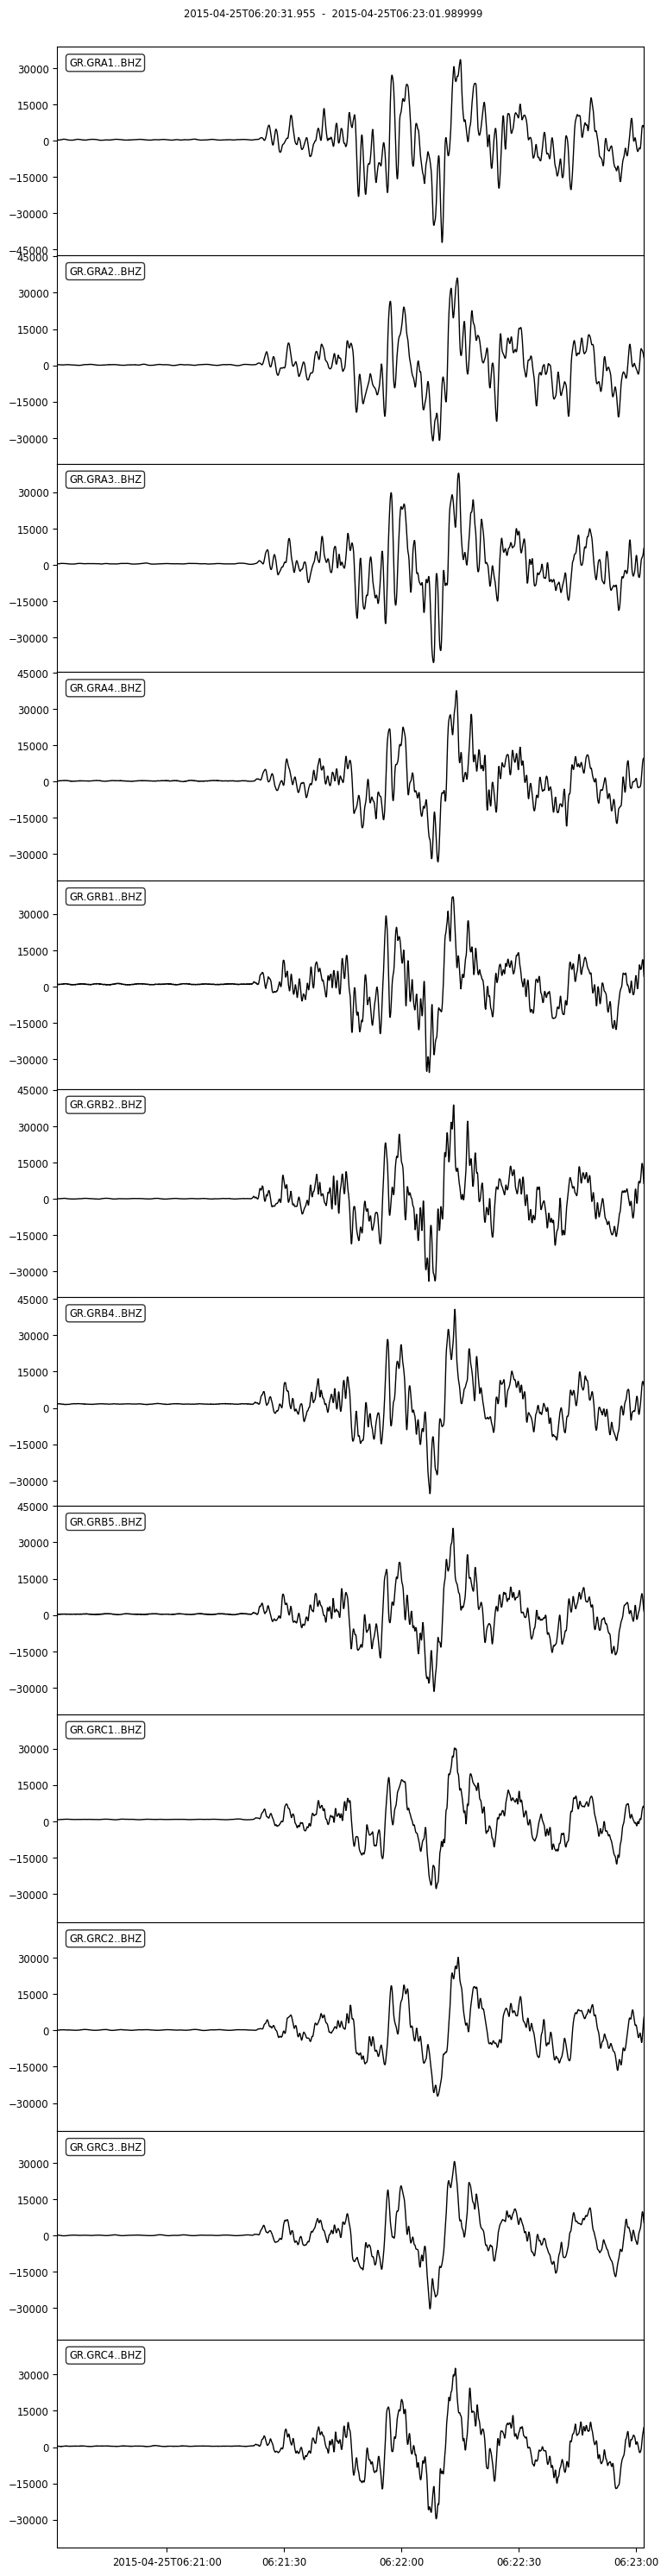

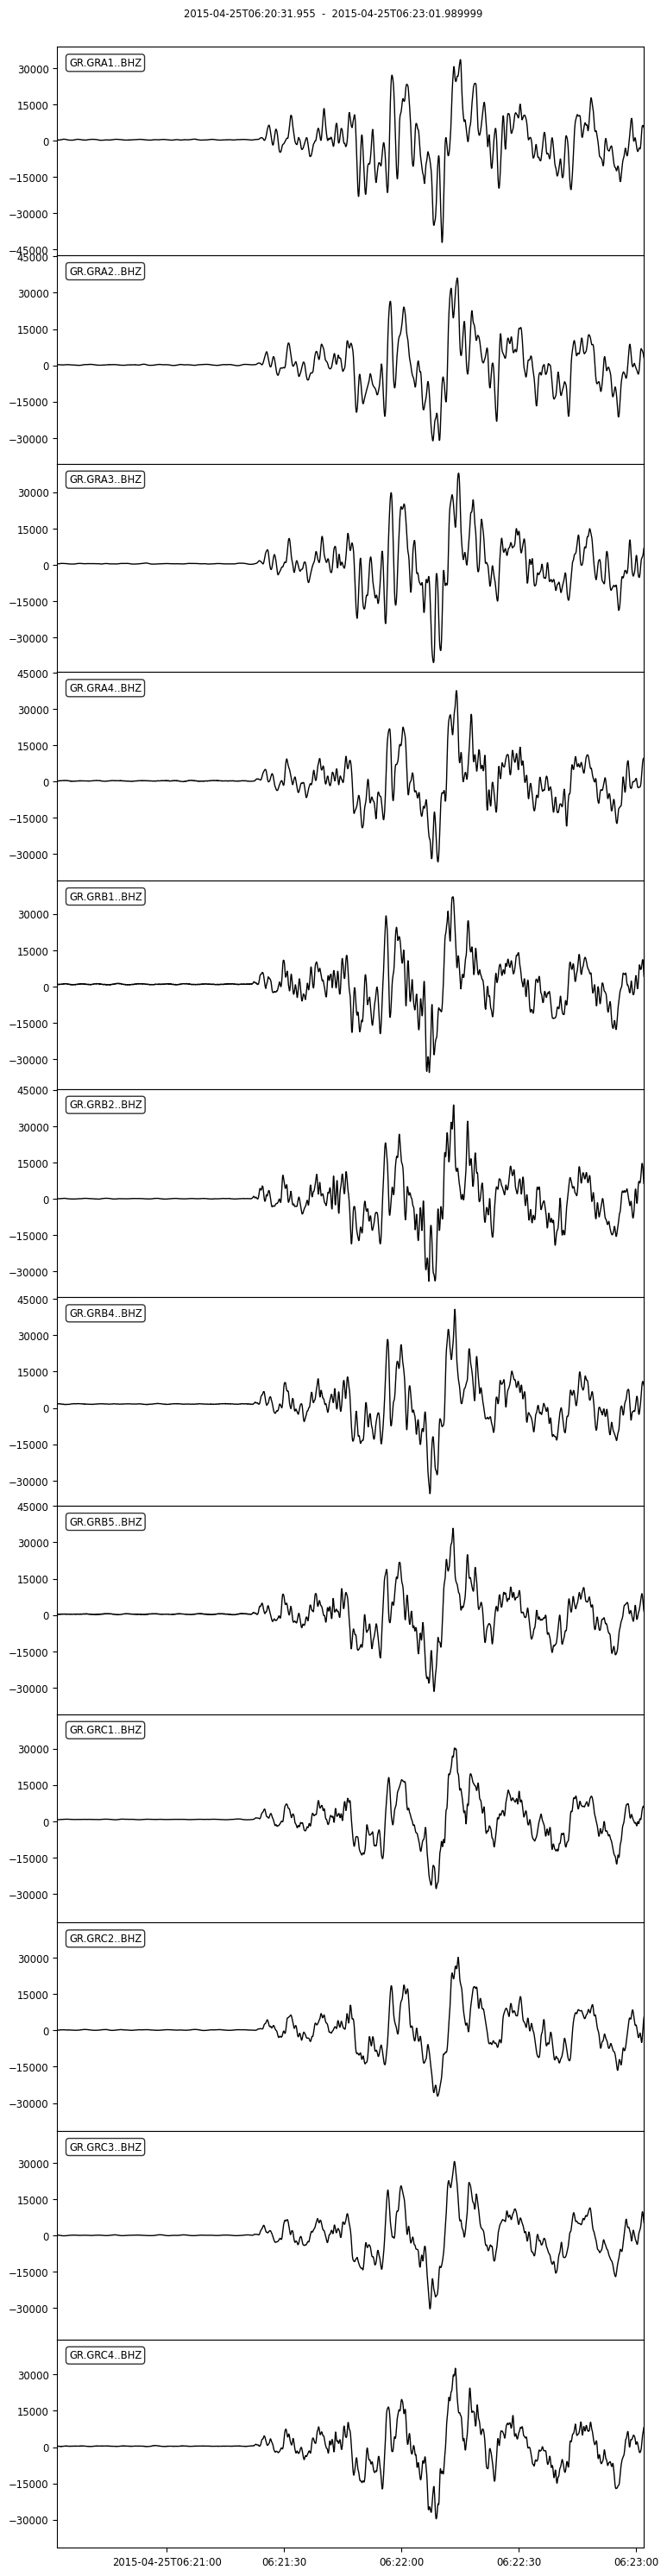

In [34]:
%matplotlib inline
print(P_arrival[7])
#"2019-11-27T07:27:24"
st=read('data/GR.GR*..BHZ.D.2015.115')
time_P=obspy.UTCDateTime(P_arrival[7])
st2=st.copy()
st2.trim(time_P-50,time_P+100)
st2.plot()

In [35]:
%matplotlib inline
print(P_arrival[7])
#"2019-11-27T07:27:24"
st=read('data/GR.GR*..BHZ.D.2015.115')
time_P=obspy.UTCDateTime(P_arrival[7])
st2=st.copy()
st2.trim(time_P-30,time_P+30)
#st2.plot()
###here should be careful, the p pick is not so accurate
start=UTCDateTime(P_arrival[7])-2
end=UTCDateTime(P_arrival[7])+20
fmin    =  0.005  
fmax    =  0.5
win_len =  15
smax    =  0.15
%matplotlib qt5
array_hist_st(st2,start,end,fmin=fmin, fmax=fmax,win_len=win_len,smax=smax, stationfile='data/station_GR.csv')

2015-4-25T06:21:22
calculating fk-diagram with:
sll_x:  -0.15
slm_x:  0.15
sll_y:  -0.15
slm_y:  0.15
sl_s:  0.003
2015-04-25T06:21:19.979999Z 2015-04-25T06:21:41.979999Z
fk processing for signal between 2015-04-25T06:21:19.979999Z and 2015-04-25T06:21:41.979999Z...


In [36]:
%matplotlib inline
print(P_arrival[8],distance[8])

2020-09-18T21:53:54 58.430680867622215


In [37]:
%matplotlib inline
print(P_arrival[8])
#"2019-11-27T07:27:24"
st=read('data/GR.GR*..BHZ.D.2020.262')
time_P=obspy.UTCDateTime(P_arrival[8])
st2=st.copy()
st2.trim(time_P-30,time_P+30)
#st2.plot()
###here should be careful, the p pick is not so accurate
start=UTCDateTime(P_arrival[8])-2
end=UTCDateTime(P_arrival[8])+20
fmin    =  0.005  
fmax    =  0.5
win_len =  15
smax    =  0.1
%matplotlib qt5
array_hist_st(st2,start,end,fmin=fmin, fmax=fmax,win_len=win_len,smax=smax, stationfile='data/station_GR.csv')

2020-09-18T21:53:54
calculating fk-diagram with:
sll_x:  -0.1
slm_x:  0.1
sll_y:  -0.1
slm_y:  0.1
sl_s:  0.002
2020-09-18T21:53:51.985000Z 2020-09-18T21:54:13.985000Z
fk processing for signal between 2020-09-18T21:53:51.985000Z and 2020-09-18T21:54:13.985000Z...


In [38]:
%matplotlib inline
print(P_arrival[9],distance[9])

2020:01:28T19:22:14 75.56319451275198


In [57]:
%matplotlib inline
print(P_arrival[9])
#"2019-11-27T07:27:24"
st=read('data/GR.GR*..BHZ.D.2020.028')
time_P=obspy.UTCDateTime(P_arrival[9])
st2=st.copy()
st2.trim(time_P-10,time_P+50)
#st2.plot()
###here should be careful, the p pick is not so accurate
start=UTCDateTime(P_arrival[9])-2
end=UTCDateTime(P_arrival[9])+20
fmin    =  0.005  
fmax    =  0.5
win_len =  15
smax    =  0.1
%matplotlib qt5
array_hist_st(st2,start,end,fmin=fmin, fmax=fmax,win_len=win_len,smax=smax, stationfile='data/station_GR.csv')

2020:01:28T19:22:14
calculating fk-diagram with:
sll_x:  -0.1
slm_x:  0.1
sll_y:  -0.1
slm_y:  0.1
sl_s:  0.002
2020-01-28T19:22:11.995000Z 2020-01-28T19:22:33.995000Z
fk processing for signal between 2020-01-28T19:22:11.995000Z and 2020-01-28T19:22:33.995000Z...


TypeError: array_hist_st() missing 3 required positional arguments: 'st', 'start', and 'end'

In [58]:
1/0.05

20.0

#### c) Create a list with the information of all earthquakes
Therefore, you should share the information with the other students and write the distance and the slowness down.

Create a np.array with distance and slowness. The list should be orderd by the distance (starting with the lowest value).
<br>E.g: <code> data=np.array([dist1,slow1],[dist2,slow2],...)</code> <br>
Convert the slowness values in s/deg!

In [40]:
data=np.array([[distance[0],0.12],\
              [distance[1],0.11],\
              [distance[2],0.10],\
              [distance[3],0.08],\
              [distance[4],0.09],\
              [distance[5],0.06],\
              [distance[6],0.08],\
              [distance[7],0.06],\
              [distance[8],0.06],\
              [distance[9],0.05]])



In [46]:
data

array([[3.77835228e+00, 1.20000000e-01],
       [1.60589053e+01, 1.10000000e-01],
       [1.74791502e+01, 1.00000000e-01],
       [2.71130955e+01, 8.00000000e-02],
       [2.89787647e+01, 9.00000000e-02],
       [4.43433491e+01, 6.00000000e-02],
       [5.53946046e+01, 8.00000000e-02],
       [5.84158817e+01, 6.00000000e-02],
       [5.84306809e+01, 6.00000000e-02],
       [7.55631945e+01, 5.00000000e-02]])

Show a scatter plot of the slowness over the epicentral distances.

In [55]:
data.T[1]*111

array([13.32, 12.21, 11.1 ,  8.88,  9.99,  6.66,  8.88,  6.66,  6.66,
        5.55])

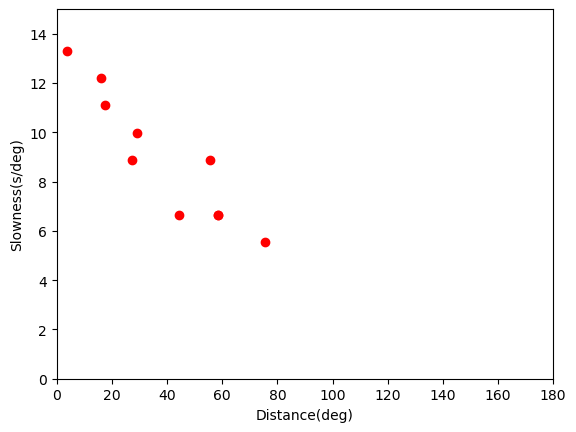

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure()
plt.scatter(data.T[0],data.T[1]*111,color='r')
#plt.scatter(distance[4],0.09*111,color='r')
#plt.scatter(distance[2],0.10*111,color='r')
#plt.scatter(distance[0],0.12*111,color='r')
#plt.scatter(distance[1],0.11*111,color='r')
#plt.scatter(distance[5],0.06*111,color='r')
#plt.scatter(distance[6],0.08*111,color='r')
#plt.scatter(distance[7],0.06*111,color='r')
#plt.scatter(distance[8],0.06*111,color='r')
#plt.scatter(distance[9],0.05*111,color='r')
plt.xlim(0,180)
plt.ylim(0,15)
plt.ylabel('Slowness(s/deg)')
plt.xlabel('Distance(deg)')
plt.show()

In [49]:
len(distance)

10

Have a look at the figure of Filson (1975). Does your own plot show similarities? <br>In which region of epicentral distances could you apply a reasonable fit to the data? Can you connect this observation with your knowledge about the Earth's structure?<br>
<img src="data/filson.png" alt="drawing" width="350"> 

For a fit to the data we have to approximate the plot by a mathematical function. As the travel time (TT) curves can be approximated by a limited growth functions and the ray parameter is the derivative of the TT-curves, we will use the derivative of a limited growth function for our data. <br>
The necessary functions are provided below.

In [42]:
from scipy.optimize import curve_fit

def derv_limited_increase(x,s,b,k):
    y=(s-b)*np.exp(-k*x)*(-k)
    return y


def fit2p(d,p,n):
    popt, pcov = curve_fit(derv_limited_increase, d, p)
    x_line=np.linspace(0,100,n)
    y_line=derv_limited_increase(x_line,*popt)
    return x_line,y_line

Fit a curve to your data and create a Figure with both your scattered data points and the fit!

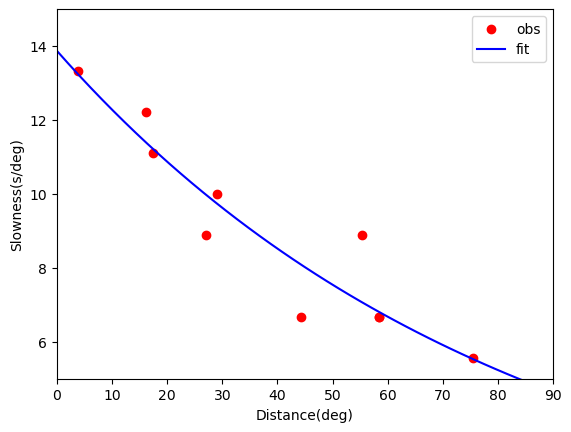

In [43]:
# create the fit by replacing the "?" with the first and second column of your list.
d,p=fit2p(data.T[0],data.T[1]*111,50) 

#create a figure with your data points and the fit
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure()
plt.scatter(data.T[0],data.T[1]*111,color='r',label='obs')
#plt.scatter(distance[4],0.09*111,color='r')
#plt.scatter(distance[2],0.10*111,color='r')
#plt.scatter(distance[0],0.12*111,color='r')
#plt.scatter(distance[1],0.11*111,color='r')
#plt.scatter(distance[5],0.06*111,color='r')
#plt.scatter(distance[6],0.08*111,color='r')
#plt.scatter(distance[7],0.06*111,color='r')
#plt.scatter(distance[8],0.06*111,color='r')
plt.plot(d,p,'b',label='fit')
plt.xlim(0,90)
plt.ylim(5,15)
plt.ylabel('Slowness(s/deg)')
plt.xlabel('Distance(deg)')
plt.legend()
plt.show()

### 2) Inversion
If the fit of the data is correct, you can move on to the inversion! Run the cell below to make the inversion-algorithm available.
   

In [44]:
from scipy import integrate
def calc_vel(dist, s, r0):
    '''
    dist:     array with float values of the distance, unit is radian
    s:        array with float values of the slowness, unit is s/deg
    r0:       integer/float with earth radius in km
    '''
    res=[]
    km2deg=111.13
    
    for i in range(len(s)):
        x=np.arccosh(s[:i+1]/(s[i]))
        A=integrate.simps(x[:i+1],dist[:i+1])
        r=r0*np.exp(-A/np.pi)
        v=r/r0/s[i]*km2deg
        res.append([r,v])
    return np.array(res)


Now, calculate the velocity model with the given inversion function. Have a look of the comment within the function, which specify the required parameters. Be careful with the units and use a earth radius of 6371km.

Text(0, 0.5, 'Velocity(km/s)')

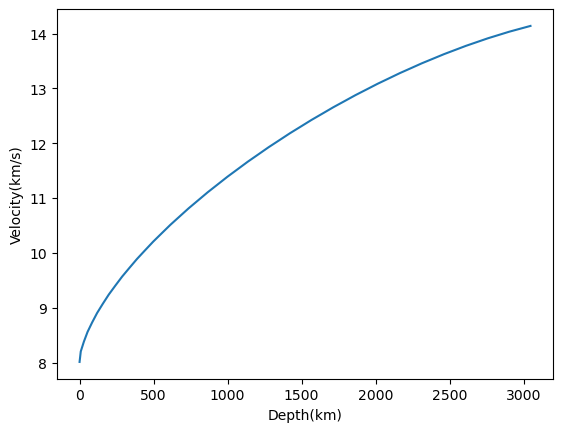

In [45]:
#carry out the inversion
velocity=calc_vel(d*np.pi/180, p, 6371)
# create a Figure, which shows the results 
plt.plot(6371-velocity.T[0],velocity.T[1])
plt.xlabel('Depth(km)')
plt.ylabel('Velocity(km/s)')

What do you think? Does your plot make sense? What is depicted? What do you know from the earth structure? <br>
<br>
Have a look at the "official" velocity model of the earth (PREM-model).<br>
Therefore read the data with: <code>r,v=np.loadtxt('data/prem.txt', unpack=True)</code>
    

In [46]:
r,v=np.loadtxt('data/prem.txt', unpack=True)


Now you can compare your results with the PREM-model in one Figure.

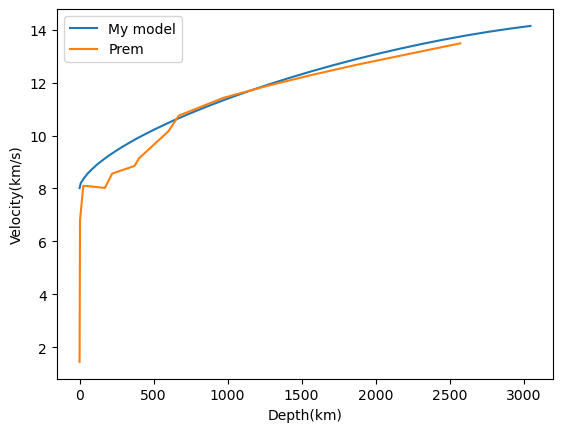

In [47]:
#create Figure

velocity=calc_vel(d*np.pi/180, p, 6371)
# create a Figure, which shows the results 
plt.plot(6371-velocity.T[0],velocity.T[1],label='My model')
plt.plot(6371-r,v,label='Prem')
plt.xlabel('Depth(km)')
plt.ylabel('Velocity(km/s)')
plt.legend()

What are similarities and differences of both model? 


### 3) Using travel time curves (bonus)

As the travel time curves are mathematically the integral of the ray parameter, we can use available travel time data (e.g. ak135 tables) to determine the 1D- velocity model. <br>
<br>
First we need a function, which calculates the derivative of a given data set. In the provided function below we use a central finite difference approach.

In [48]:
def derivative(x,y):
    deriv_y=[]
    x_new=[]
    for i in range(1,len(y)-1):
        deriv_y.append((y[i+1]-y[i-1])/abs(x[i+1]-x[i-1]))
        x_new.append(x[i])
    deriv_y=np.array(deriv_y)
    x_new=np.array(x_new)
    
    return x_new,deriv_y


In the file "traveltimes.txt" (located in the folder "data") we provided epicentral distances (1st column) with the the related travel times (2nd column). <br>
Use <code>d,t=np.loadtext(filename, unpack=True)</code> to read the data.

In [49]:
d,t=np.loadtxt('data/traveltimes.txt', unpack=True)

In the next step we determine the ray parameter by calculating the derivative. Use the provided function <code>derivative()</code>.

In [50]:
new_distance,difftrav=derivative(d,t)


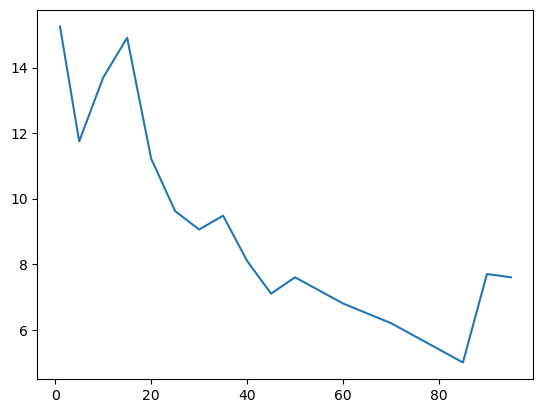

In [51]:
plt.plot(new_distance,difftrav)

Similar to our procedure before, we now fit a curve to our data (<code>fit2p()</code>) and then carry out the inversion (<code>calc_vel()</code>). Be careful with the units of your data!

/tmp/ipykernel_8870/1832890152.py:4: RuntimeWarning: overflow encountered in exp
  y=(s-b)*np.exp(-k*x)*(-k)


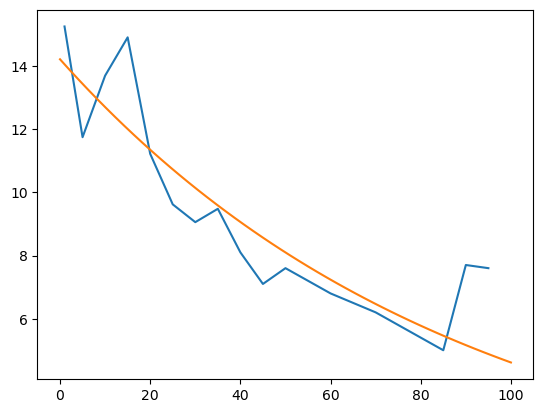

In [52]:
#fit a curve to the data
raypar=difftrav.copy()
plt.plot(new_distance,raypar)

d,p=fit2p(new_distance,raypar,50) 
plt.plot(d,p)
plt.show()
velocity=calc_vel(d*np.pi/180, p, 6371)
#carry out inversion

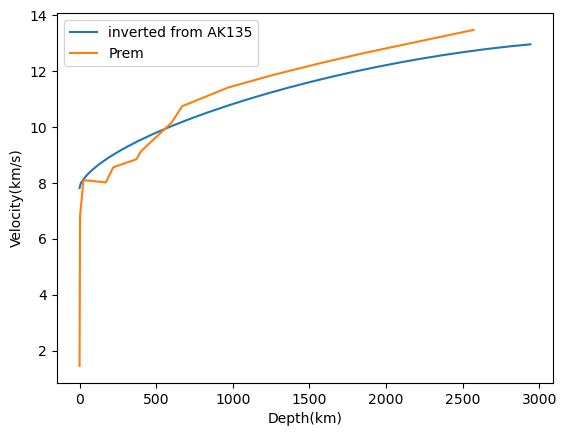

In [53]:
plt.plot(6371-velocity.T[0],velocity.T[1],label='inverted from AK135')
plt.plot(6371-r,v,label='Prem')
plt.xlabel('Depth(km)')
plt.ylabel('Velocity(km/s)')
plt.legend()

Plot all three velocity models
- the prem-model
- the model derived with array analysis
- the model derived with the travel time curves

in one Figure. 

In [ ]:
# create Figure